## Shape protrusion distance
The protrusion distance refers to the proportion of the smaller molecule that protrudes from the larger molecule (therefore, we can work out the overlap between the two molecules).

I found when running this that the amount of protrusion depends on the protein file used. When I looked at the overlap between the fragment and the proteins - the amount they overlapped with the different proteins also varied.

Workflow:
For each merge - get the protein file for each original fragment (so we have protein A and protein B)
Calculate the protrusion distance between the merge and each protein
Take the geometric mean of the two distances

Either:
Use a 5% overlap cut-off (i.e. if the overlap (using the calculated mean) of the merge with the protein is >5%, then do not use these merges, as the minimisation will not be able to compensate for big overlaps).
Calculate the protrusion distance of the fragments with the proteins and proportionally get the 5% cut-off

## Imports

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw, PandasTools
import pandas as pd

sys.path.insert(1, '/home/sabsr3/xchem/fragment_network_merges/scripts')
from OverlapFilter import *

## Filter

Playing around with the data first to find the best way to filter

,Merge,Fragment A ID,Fragment A smiles,Fragment B ID,Fragment B smiles,Synthon,Smiles,Target ID,Target smiles,Fragment A file,Fragment B file,Embedded
0,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)CN1CCC2(C1)CC1(C2)OCCO1,x0678,O=C(CC1CCCCC1)Nc1cccnc1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,
1,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)CN1CCN(Cc2ccncc2)CC1,x0678,O=C(CC1CCCCC1)Nc1cccnc1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,
2,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)CC1CCNc2cc3c(cc21)OCCO3,x0678,O=C(CC1CCCCC1)Nc1cccnc1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,
3,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)CN1C2CCC1CC(=C1CCC1)C2,x0678,O=C(CC1CCCCC1)Nc1cccnc1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,
4,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)CN1CCCC2(CCCCCC2)C1,x0678,O=C(CC1CCCCC1)Nc1cccnc1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,

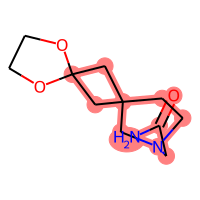
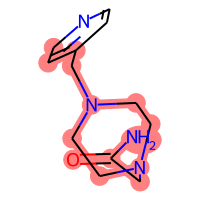
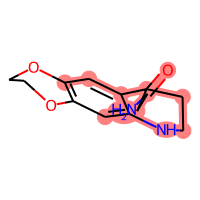
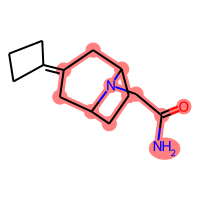
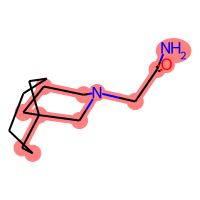

In [2]:
PandasTools.RenderImagesInAllDataFrames(images=True)  # line needed to render the rdkit images in the saved csv
df = pd.read_csv('/home/sabsr3/xchem/fragment_network_merges/data/filtered/embeddedFiltered.csv')
df.head()

In [3]:
# get filepaths of proteins
path = '/home/sabsr3/xchem/fragment_network_merges/data/Mpro/aligned/Mpro-FRAG_0A/Mpro-FRAG_0A_apo-desolv.pdb'

def get_filepaths(frag):
    return path.replace('FRAG', frag)

df['Fragment A protein file'] = df.apply(lambda x: get_filepaths(x['Fragment A ID']), axis=1)
df['Fragment B protein file'] = df.apply(lambda x: get_filepaths(x['Fragment B ID']), axis=1)

,Merge,Fragment A ID,Fragment A smiles,Fragment B ID,Fragment B smiles,Synthon,Smiles,Target ID,Target smiles,Fragment A file,Fragment B file,Embedded,Fragment A protein file,Fragment B protein file
0,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)CN1CCC2(C1)CC1(C2)OCCO1,x0678,O=C(CC1CCCCC1)Nc1cccnc1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...
1,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)CN1CCN(Cc2ccncc2)CC1,x0678,O=C(CC1CCCCC1)Nc1cccnc1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...
2,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)CC1CCNc2cc3c(cc21)OCCO3,x0678,O=C(CC1CCCCC1)Nc1cccnc1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...
3,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)CN1C2CCC1CC(=C1CCC1)C2,x0678,O=C(CC1CCCCC1)Nc1cccnc1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...
4,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)CN1CCCC2(CCCCCC2)C1,x0678,O=C(CC1CCCCC1)Nc1cccnc1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...

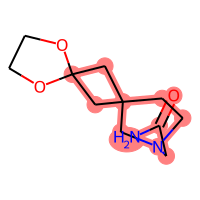
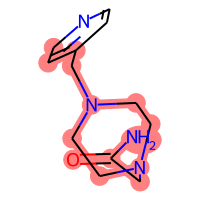
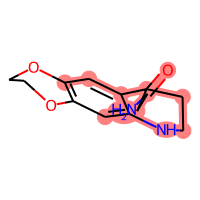
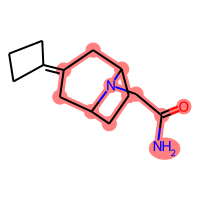
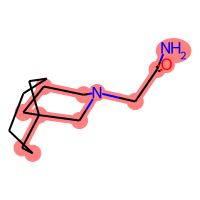

In [4]:
df.head()

In [ ]:
fraga_files = [i for i in df['Fragment A file']]
fragb_files = [i for i in df['Fragment B file']]
fraga_protein_files = [i for ]

,Merge,Fragment A ID,Fragment A smiles,Fragment B ID,Fragment B smiles,Synthon,Smiles,Target ID,Target smiles,Fragment A file,Fragment B file,Embedded,Fragment A protein file,Fragment B protein file
0,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)CN1CCC2(C1)CC1(C2)OCCO1,x0678,O=C(CC1CCCCC1)Nc1cccnc1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...
1,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)CN1CCN(Cc2ccncc2)CC1,x0678,O=C(CC1CCCCC1)Nc1cccnc1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...
2,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)CC1CCNc2cc3c(cc21)OCCO3,x0678,O=C(CC1CCCCC1)Nc1cccnc1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...
3,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)CN1C2CCC1CC(=C1CCC1)C2,x0678,O=C(CC1CCCCC1)Nc1cccnc1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...
4,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)CN1CCCC2(CCCCCC2)C1,x0678,O=C(CC1CCCCC1)Nc1cccnc1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...

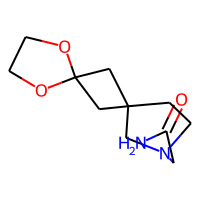
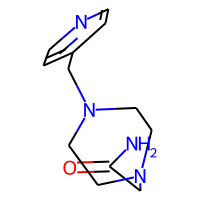
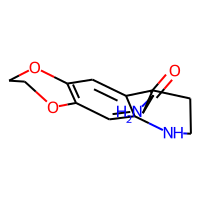
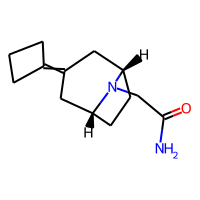
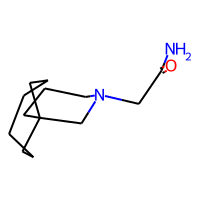

In [5]:
# replace embedded column with mols from sdf file as distance calculation doesn't work otherwise
suppl = Chem.SDMolSupplier('/home/sabsr3/xchem/fragment_network_merges/data/filtered/embeddedMols.sdf')
mols = [x for x in suppl]
df['Embedded'] = mols
df.head()

In [6]:
test_df = df.iloc[:10]

6097it [06:39, 15.25it/s]
Number of molecules: 1913


,Merge,Fragment A ID,Fragment A smiles,Fragment B ID,Fragment B smiles,Synthon,Smiles,Target ID,Target smiles,Fragment A file,Fragment B file,Embedded,Fragment A protein file,Fragment B protein file
0,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)CN1CCC2(C1)CC1(C2)OCCO1,x0678,O=C(CC1CCCCC1)Nc1cccnc1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...
1,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)CN1CCN(Cc2ccncc2)CC1,x0678,O=C(CC1CCCCC1)Nc1cccnc1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...
2,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,NC(=O)C[Xe],NC(=O)CN1CCCC2(CCCCCC2)C1,x0678,O=C(CC1CCCCC1)Nc1cccnc1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...
3,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,[Xe]C1CCCCC1,CCC(OC1CCCCC1)C(=O)Nc1cnccc1C,x0678,O=C(CC1CCCCC1)Nc1cccnc1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...
4,x0107_x0678t,x0107,CC(=O)Nc1cnccc1C,x0678,NC(=O)CC1CCCCC1,[Xe]C1CCCCC1,COC(C(=O)Nc1cnccc1C)C1CCCCC1,x0678,O=C(CC1CCCCC1)Nc1cccnc1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,x0107_x1382,x0107,CC(=O)Nc1cnccc1C,x1382,CC(NC(=O)CCl)c1cccc(Cl)c1,[Xe]c1cccc([Xe])c1,Cc1ccncc1NC(=O)Cc1cccc(F)c1,x2646,Cc1ccncc1NC(=O)Cc1cccc(Cl)c1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...
1909,x0107_x1382,x0107,CC(=O)Nc1cnccc1C,x1382,CC(NC(=O)CCl)c1cccc(Cl)c1,[Xe]c1cccc([Xe])c1,Cc1ccncc1NC(=O)Cc1cccc(Cl)c1,x2646,Cc1ccncc1NC(=O)Cc1cccc(Cl)c1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...
1910,x0107_x1382,x0107,CC(=O)Nc1cnccc1C,x1382,CC(NC(=O)CCl)c1cccc(Cl)c1,[Xe]c1cccc([Xe])c1,O=C(Cc1cccc(F)c1)Nc1cccnc1,x2646,Cc1ccncc1NC(=O)Cc1cccc(Cl)c1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...
1911,x0107_x1382,x0107,CC(=O)Nc1cnccc1C,x1382,CC(NC(=O)CCl)c1cccc(Cl)c1,[Xe]c1cccc([Xe])c1,C=C1CCC(NC(=O)Cc2cccc(C)c2)CC1,x2646,Cc1ccncc1NC(=O)Cc1cccc(Cl)c1,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...,,/home/sabsr3/xchem/fragment_network_merges/dat...,/home/sabsr3/xchem/fragment_network_merges/dat...

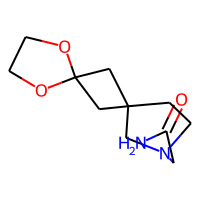
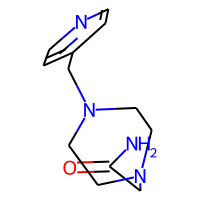
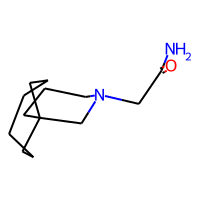
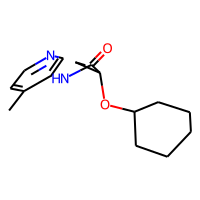
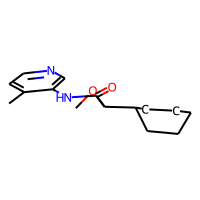
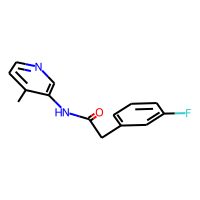
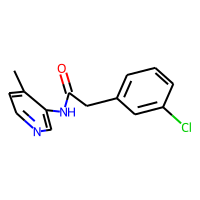
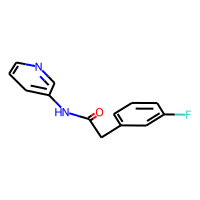
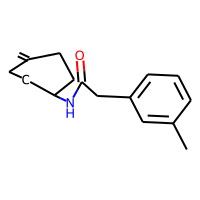
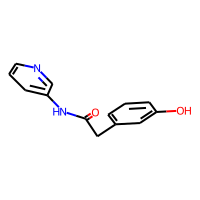

In [7]:
OverlapFilterDf(df).fixed_cutoff_filter()